In [52]:
# !pip install seaborn
# !pip install statsmodels
# !pip install pmdarima
# !pip install --upgrade numpy
# !pip install nbformat



In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import wandb
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
# from pmdarima.arima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error,root_mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from prophet import Prophet
from prophet.plot import plot_plotly,plot_components_plotly
from prophet.diagnostics import cross_validation, performance_metrics

In [54]:
wandb.init(project="Energy-Consumption-Pred-101",name = 'EDA',job_type="eda")

adfullerResult,▁
adfullerResult,0


In [55]:
df = pd.read_csv("Energy_consumption.csv")

In [56]:
wandb.log({'data_shape':df.shape})

In [57]:
#saving the original data for our tracking
data_artifact = wandb.Artifact('original_data', type='dataset')
data_artifact.add_file('Energy_consumption.csv')
wandb.log_artifact(data_artifact)

<Artifact original_data>

In [58]:
#now creating the artifact fo rthe refrence data set
data_artifact = wandb.Artifact('reference_data', type='dataset')
data_artifact.add_file('Energy_consumption.csv')
wandb.log_artifact(data_artifact)

<Artifact reference_data>

In [59]:
display(df.head())

,Timestamp,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption
0,2022-01-01 00:00:00,25.139433,43.431581,1565.693999,5,On,Off,2.774699,Monday,No,75.364373
1,2022-01-01 01:00:00,27.731651,54.225919,1411.064918,1,On,On,21.831384,Saturday,No,83.401855
2,2022-01-01 02:00:00,28.704277,58.907658,1755.715009,2,Off,Off,6.764672,Sunday,No,78.270888
3,2022-01-01 03:00:00,20.080469,50.371637,1452.316318,1,Off,On,8.623447,Wednesday,No,56.519850
4,2022-01-01 04:00:00,23.097359,51.401421,1094.130359,9,On,Off,3.071969,Friday,No,70.811732


In [60]:
#now logginng the base inforamtion in the wandb
display(df.info())
data_description = df.describe()
display(data_description)
wandb.log({"data_description": wandb.Table(data=data_description)})

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Timestamp          1000 non-null   object 
 1   Temperature        1000 non-null   float64
 2   Humidity           1000 non-null   float64
 3   SquareFootage      1000 non-null   float64
 4   Occupancy          1000 non-null   int64  
 5   HVACUsage          1000 non-null   object 
 6   LightingUsage      1000 non-null   object 
 7   RenewableEnergy    1000 non-null   float64
 8   DayOfWeek          1000 non-null   object 
 9   Holiday            1000 non-null   object 
 10  EnergyConsumption  1000 non-null   float64
dtypes: float64(5), int64(1), object(5)
memory usage: 86.1+ KB


None

,Temperature,Humidity,SquareFootage,Occupancy,RenewableEnergy,EnergyConsumption
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,24.982026,45.395412,1500.052488,4.581000,15.132813,77.055873
std,2.836850,8.518905,288.418873,2.865598,8.745917,8.144112
min,20.007565,30.015975,1000.512661,0.000000,0.006642,53.263278
25%,22.645070,38.297722,1247.108548,2.000000,7.628385,71.544690
50%,24.751637,45.972116,1507.967426,5.000000,15.072296,76.943696
75%,27.418174,52.420066,1740.340165,7.000000,22.884064,82.921742
max,29.998671,59.969085,1999.982252,9.000000,29.965327,99.201120


In [61]:
df['Timestamp']= pd.to_datetime(df['Timestamp'])
df=df.set_index('Timestamp')#no need of formating our time data is perfect as we need it to
df=df.asfreq('h')


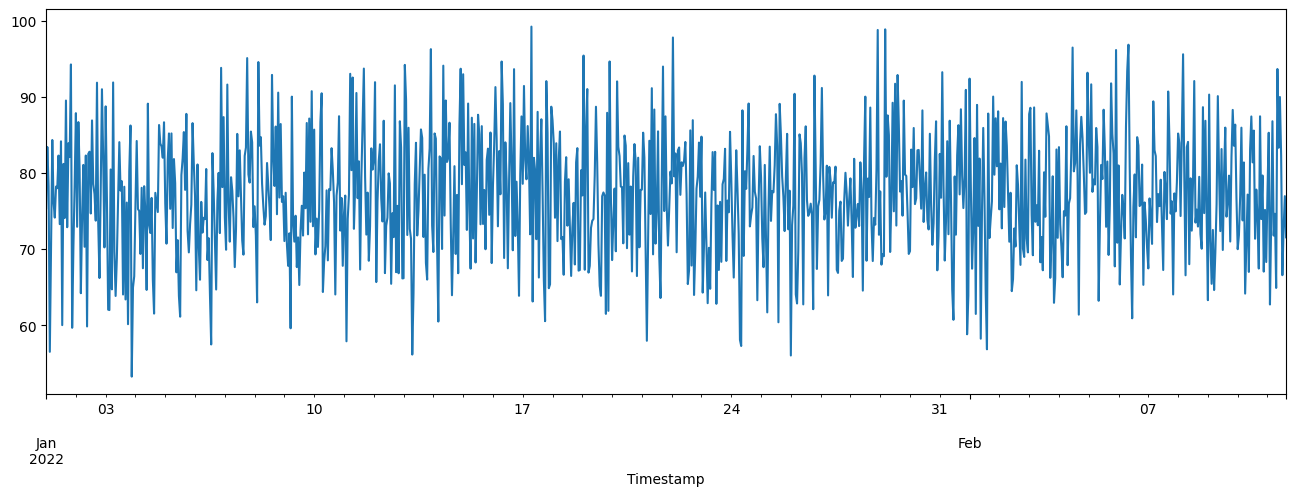

In [62]:
energy_consumption_display=df['EnergyConsumption'].plot(figsize=(16,5))
plt.show()
wandb.log({
    'energy_consumption_display': wandb.Image(energy_consumption_display.get_figure()),
})

In [63]:
result = adfuller(df['EnergyConsumption'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
wandb.log({'adfullerResult':result[1]})

ADF Statistic: -31.576934
p-value: 0.000000


<Figure size 1600x500 with 0 Axes>

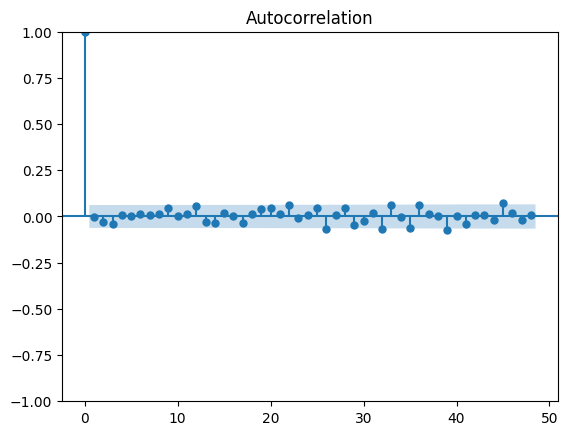

In [64]:
plt.figure(figsize=(16,5))
ACF=plot_acf(df['EnergyConsumption'],lags=48)
plt.show()
wandb.log({
    'ACF': wandb.Image(ACF.get_figure()),
})

<Figure size 1600x500 with 0 Axes>

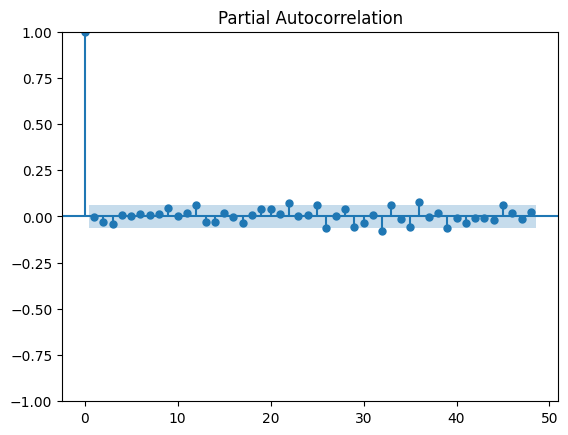

In [65]:
plt.figure(figsize=(16,5))
PACF=plot_pacf(df['EnergyConsumption'],lags=48)
plt.show()
wandb.log({
    'PACF': wandb.Image(PACF.get_figure()),
})

<Figure size 1800x1000 with 0 Axes>

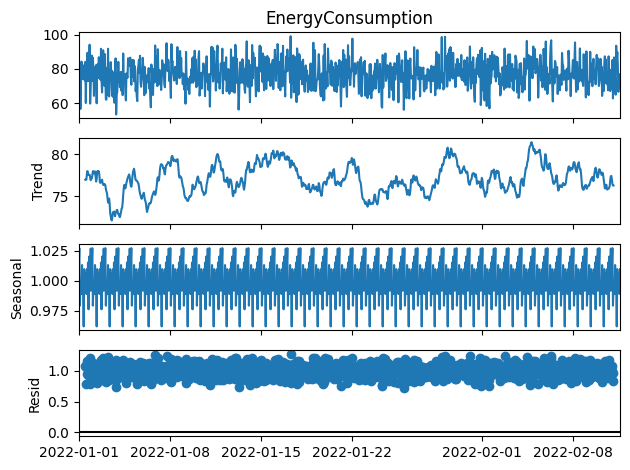

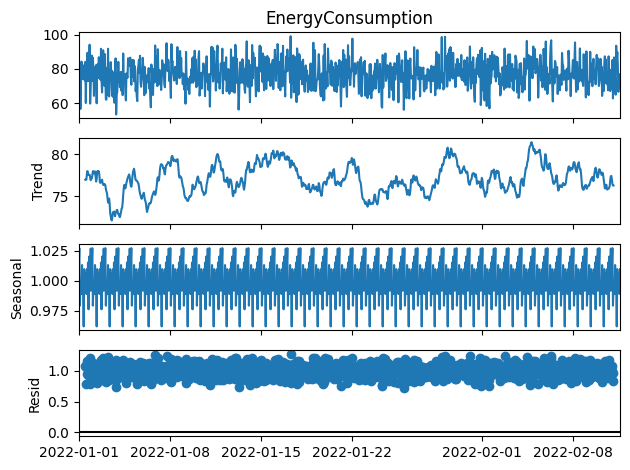

In [66]:
decomposition = seasonal_decompose(df['EnergyConsumption'],model='mul',period=24)
plt.figure(figsize=(18,10))
decomposition.plot()
plt.show()
wandb.log(
    {
        'seasonal_decomposition': wandb.Image(decomposition.plot().get_figure())


    }
)

<Figure size 1800x1000 with 0 Axes>

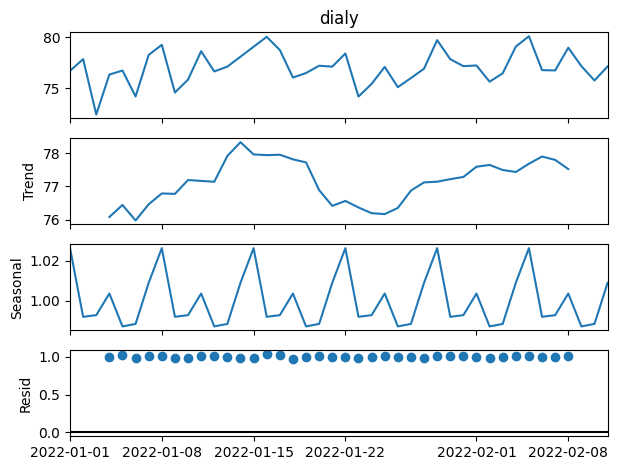

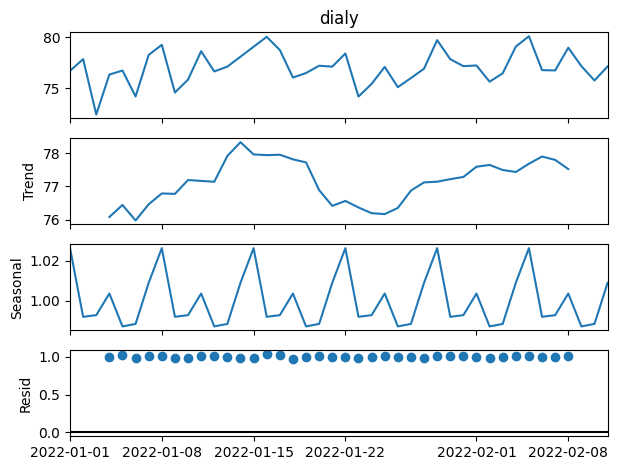

In [67]:
# now decompposing the data in a dialy manner
df1=pd.DataFrame()
df1['dialy']= df['EnergyConsumption'].resample('D').mean()
df1['dialy'].isna().value_counts()
decomposition_dialy = seasonal_decompose(df1['dialy'],model='mul',period=7)
plt.figure(figsize=(18,10))
decomposition_dialy.plot()
plt.show()
wandb.log(
    {
        'seasonal_decomposition_dialy': wandb.Image(decomposition_dialy.plot().get_figure())
    }
)

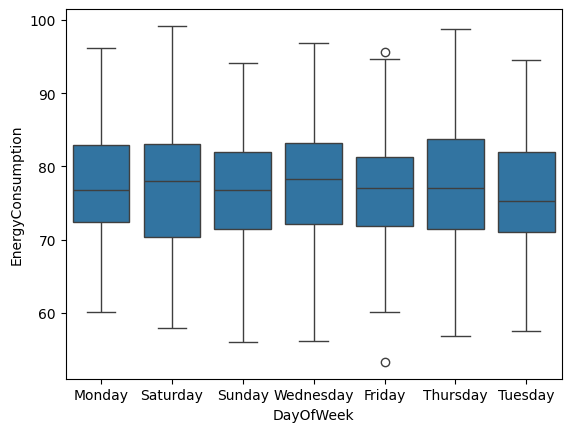

In [68]:
weekly_consumption=sns.boxplot(x='DayOfWeek',y='EnergyConsumption',data=df)
plt.show()
wandb.log({
    'weekly_consumption': wandb.Image(weekly_consumption.get_figure())
})

In [69]:
#creating the dataframe with no catogarical data
df2 = df.copy()
df2.drop(columns = ['HVACUsage','LightingUsage','DayOfWeek','Holiday'],inplace=True)


# Save the DataFrame to a CSV file first
df2.to_csv('data_without_categorical.csv', index=False)

# Create and log the artifact
artifact = wandb.Artifact(name='data_without_categorical', type='dataset')
artifact.add_file('data_without_categorical.csv')  

wandb.log_artifact(artifact)




<Artifact data_without_categorical>

In [70]:
df2=df2.resample('D').mean()
df2.head()

,Temperature,Humidity,SquareFootage,Occupancy,RenewableEnergy,EnergyConsumption
Timestamp,,,,,,
2022-01-01,25.074759,44.371927,1474.459872,4.291667,12.253233,76.710742
2022-01-02,24.844907,45.729157,1467.547720,5.625000,15.196179,77.851705
2022-01-03,24.078186,44.969077,1492.085972,5.458333,14.319790,72.442427
2022-01-04,24.905928,44.973538,1502.538303,5.875000,15.829480,76.341406
2022-01-05,24.905377,48.587588,1387.112836,5.375000,16.028968,76.738085


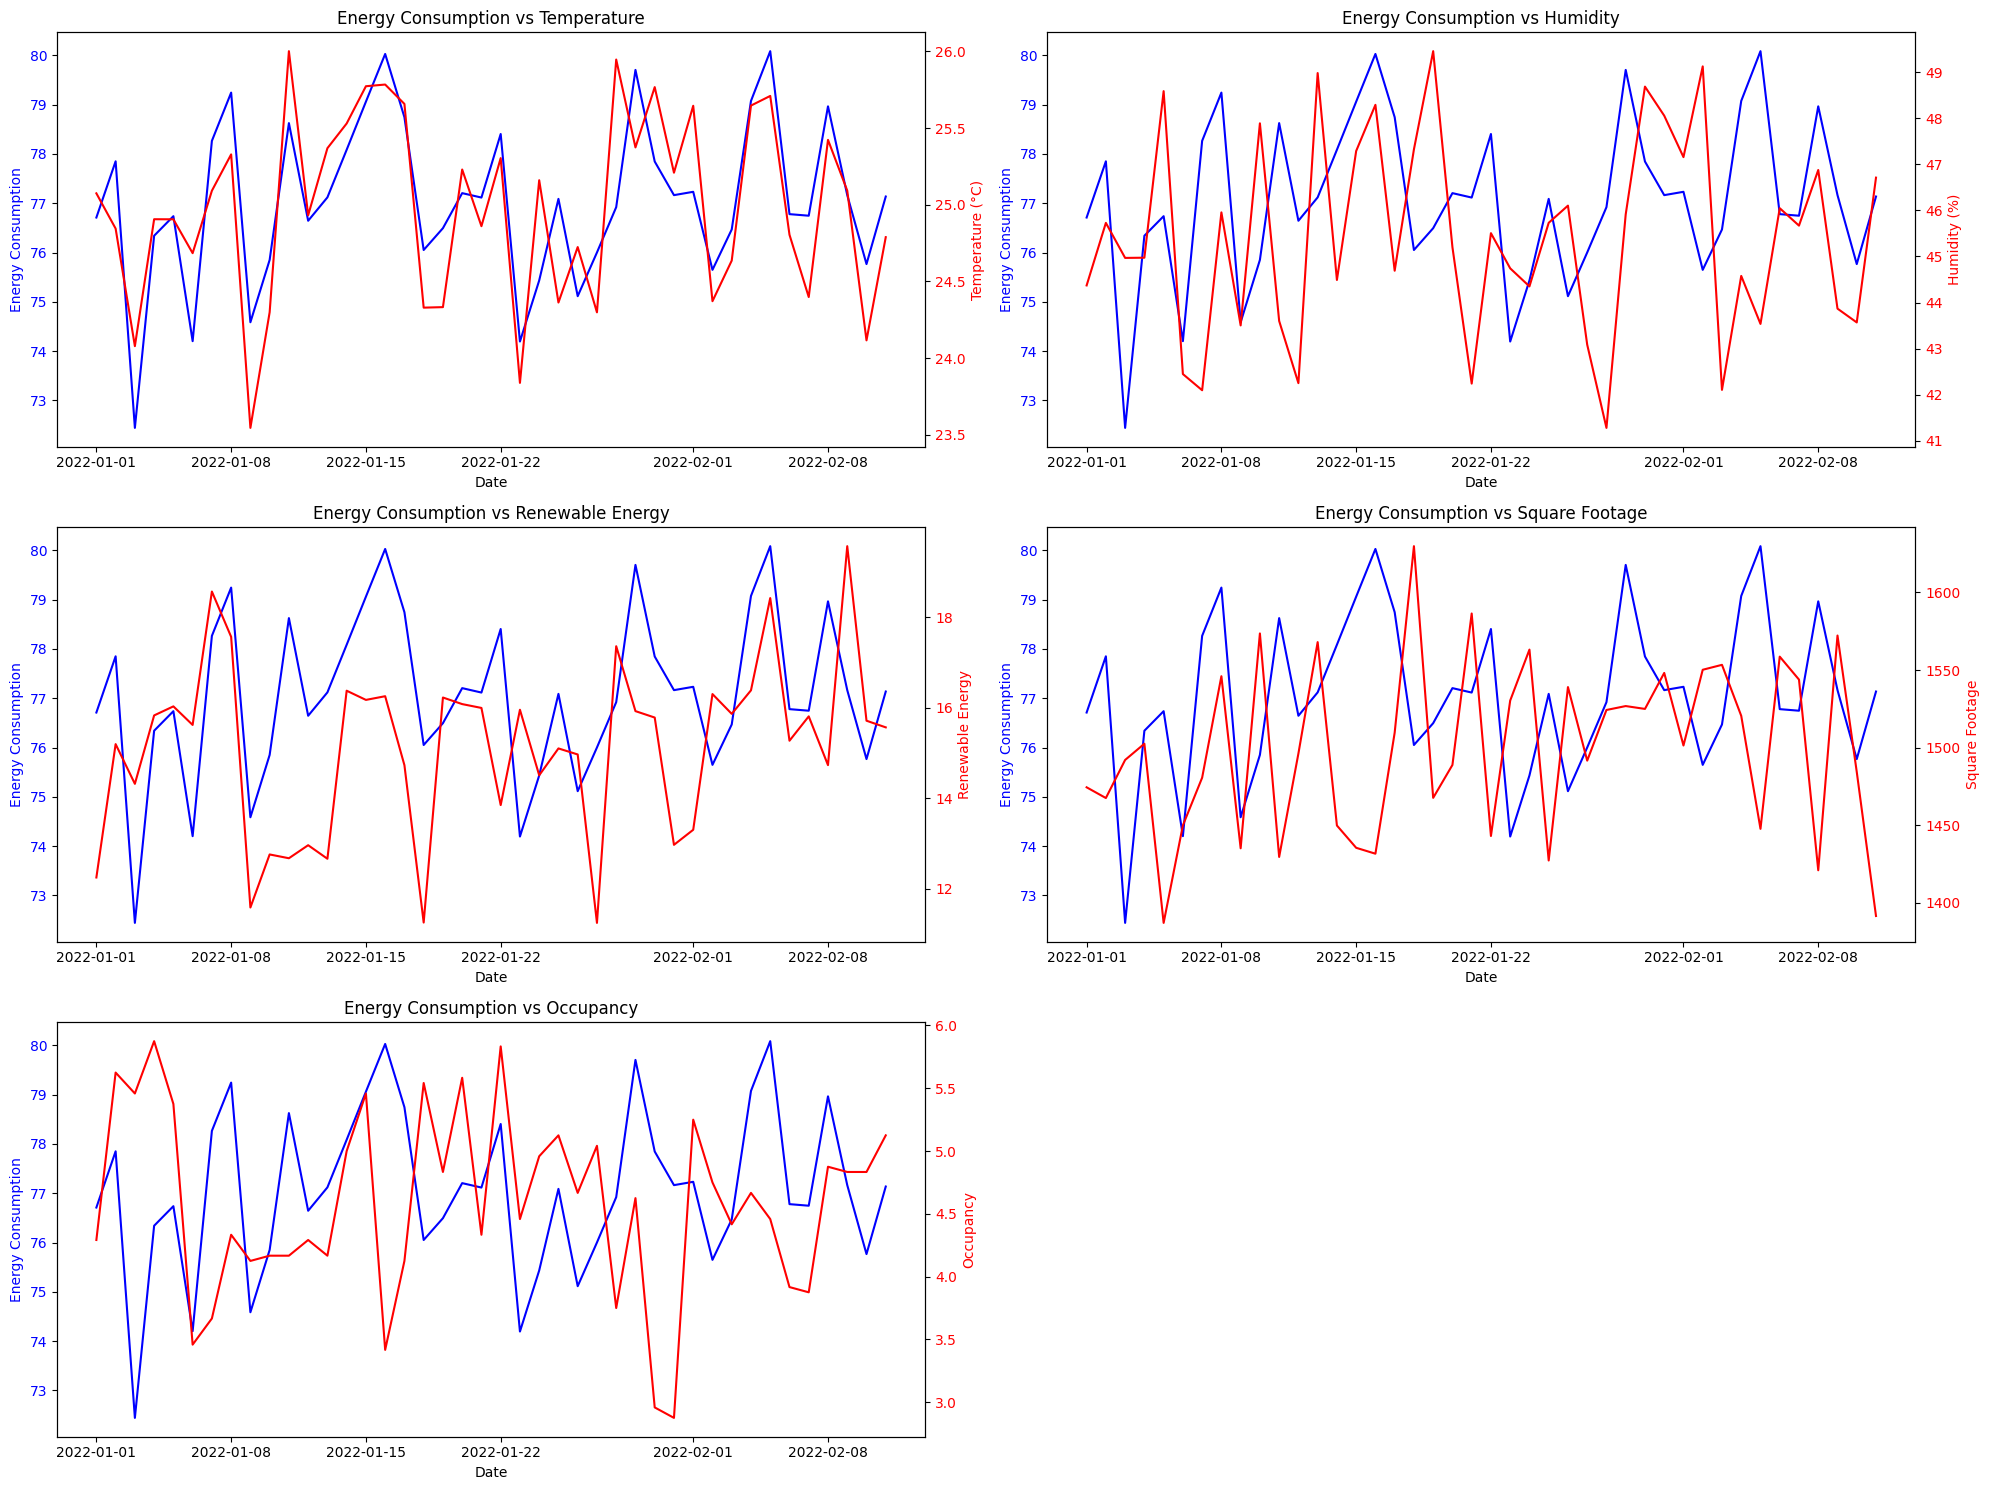

In [71]:
fig, axes = plt.subplots(3, 2, figsize=(20, 15))  # 3x2 layout for 5 plots
axes = axes.flatten()

# 1. Energy Consumption vs Temperature
ax1 = axes[0]
ax1.plot(df2.index, df2['EnergyConsumption'], color='blue')
ax1.set_ylabel('Energy Consumption', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Energy Consumption vs Temperature')
ax2 = ax1.twinx()
ax2.plot(df2.index, df2['Temperature'], color='red')
ax2.set_ylabel('Temperature (°C)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# 2. Energy Consumption vs Humidity
ax1 = axes[1]
ax1.plot(df2.index, df2['EnergyConsumption'], color='blue')
ax1.set_ylabel('Energy Consumption', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Energy Consumption vs Humidity')
ax2 = ax1.twinx()
ax2.plot(df2.index, df2['Humidity'], color='red')
ax2.set_ylabel('Humidity (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# 3. Energy Consumption vs Renewable Energy
ax1 = axes[2]
ax1.plot(df2.index, df2['EnergyConsumption'], color='blue')
ax1.set_ylabel('Energy Consumption', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Energy Consumption vs Renewable Energy')
ax2 = ax1.twinx()
ax2.plot(df2.index, df2['RenewableEnergy'], color='red')
ax2.set_ylabel('Renewable Energy', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# 4. Energy Consumption vs Square Footage
ax1 = axes[3]
ax1.plot(df2.index, df2['EnergyConsumption'], color='blue')
ax1.set_ylabel('Energy Consumption', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Energy Consumption vs Square Footage')
ax2 = ax1.twinx()
ax2.plot(df2.index, df2['SquareFootage'], color='red')
ax2.set_ylabel('Square Footage', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# 5. Energy Consumption vs Occupancy
ax1 = axes[4]
ax1.plot(df2.index, df2['EnergyConsumption'], color='blue')
ax1.set_ylabel('Energy Consumption', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Energy Consumption vs Occupancy')
ax2 = ax1.twinx()
ax2.plot(df2.index, df2['Occupancy'], color='red')
ax2.set_ylabel('Occupancy', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Hide unused 6th subplot
fig.delaxes(axes[5])

# Final layout
for ax in axes[:5]:
    ax.set_xlabel('Date')

plt.tight_layout()

# Save *before* showing
plot_path = "energy_multi_plot.png"
plt.savefig(plot_path)

# Log to wandb
wandb.log({
    'energy_multi_plot': wandb.Image(plot_path)
})

# Then show
plt.show()

# End wandb run
# ÷wandb.finish()


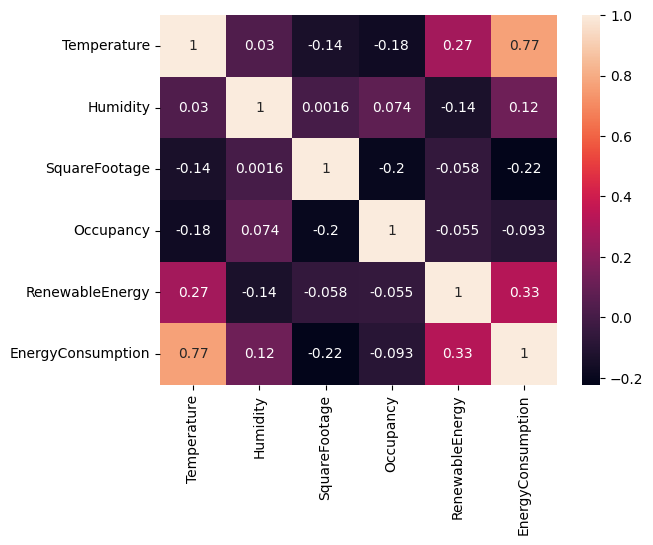

In [72]:
correlation_od_variable = sns.heatmap(df2.corr(),annot=True)
plt.show()
wandb.log({
    'correlation_od_variable': wandb.Image(correlation_od_variable.get_figure())
})